In [1]:
import pandas as pd
import numpy as np
import torch.multiprocessing as mp
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, MinMaxScaler
from LEN_Scorer import Scorer
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
import copy

In [2]:
mimicDF = pd.read_csv('../LEN_Test/data/StaticData.csv')
targetDF = mimicDF[['deathperiod']]
mimicDF = mimicDF.drop(columns=['PatientID', 'deathperiod'])

categorisationTypes = {}

In [3]:
mimicDF.head()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,NaN,0.0,3.0,3.0
1,2,0,75.00,4,2,NaN,0.0,0.0,1.0,NaN,1.0
2,16,0,51.92,4,2,NaN,0.0,NaN,0.0,NaN,2.0
3,12,0,51.73,-13,4,2.0,2.0,NaN,0.0,NaN,0.0
4,7,0,62.07,0,3,0.0,2.0,NaN,1.0,NaN,0.0


In [4]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,3311.000000,5227.000000,2254.000000,5261.000000,1294.000000,5212.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,1.987315,0.674957,0.696983,1.017297,3.238022,0.768611
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.374066,0.892066,1.051290,1.263514,0.706116,1.140061
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.000000,1.000000,1.000000,2.000000,4.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [5]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 4778 containing NaN values


### Missing values dealt with by filling with the mode.

In [6]:
for col in mimicDF:
    mimicDF[col] = mimicDF[col].fillna(mimicDF[col].mode()[0])

In [8]:
mimicDF

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
0,9,1,74.19,7,7,0.0,1.0,0.0,0.0,3.0,3.0
1,2,0,75.00,4,2,3.0,0.0,0.0,1.0,3.0,1.0
2,16,0,51.92,4,2,3.0,0.0,0.0,0.0,3.0,2.0
3,12,0,51.73,-13,4,2.0,2.0,0.0,0.0,3.0,0.0
4,7,0,62.07,0,3,0.0,2.0,0.0,1.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
5257,120,1,36.61,5,10,3.0,3.0,4.0,0.0,3.0,0.0
5258,13,0,53.90,12,4,3.0,0.0,0.0,0.0,3.0,1.0
5259,4,0,58.93,18,5,3.0,1.0,0.0,4.0,3.0,0.0
5260,16,0,68.98,-4,3,1.0,2.0,0.0,0.0,3.0,0.0


In [9]:
mimicDF.describe()

,los,gender,age,comorbidity,sofa,respiration,coagulation,liver,renal,cardiovascular,cns
count,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000,5262.00000,5262.000000,5262.000000,5262.000000,5262.000000,5262.000000
mean,14.668757,0.382554,75.049002,9.801026,4.794185,2.36279,0.670468,0.298556,1.017104,3.058533,0.761307
std,14.101457,0.486057,50.553676,9.671438,2.694694,1.19465,0.890785,0.769595,1.263472,0.364759,1.137079
min,1.000000,0.000000,16.010000,-16.000000,2.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,0.000000,55.410000,2.000000,3.000000,2.00000,0.000000,0.000000,0.000000,3.000000,0.000000
50%,10.000000,0.000000,68.300000,9.000000,4.000000,3.00000,0.000000,0.000000,1.000000,3.000000,0.000000
75%,18.000000,1.000000,78.525000,16.000000,6.000000,3.00000,1.000000,0.000000,2.000000,3.000000,1.000000
max,202.000000,1.000000,306.880000,47.000000,22.000000,4.00000,4.000000,4.000000,4.000000,4.000000,4.000000


In [10]:
rowsWithNaN = sum(mimicDF.isnull().any(axis=1))
print(f"{mimicDF.shape[0]} rows in df, {rowsWithNaN} containing NaN values")

5262 rows in df, 0 containing NaN values


#### Replaced NaN values with average of respective columns

In [11]:
dataNeedingEncodingDF = mimicDF[['los', 'age', 'comorbidity', 'sofa']]

### Fixing high age range

In [12]:
ageWithoutOutliers = dataNeedingEncodingDF['age'][dataNeedingEncodingDF['age'] < 200]

dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))

dataNeedingEncodingDF.head()

C:\Users\benma\AppData\Local\Temp/ipykernel_25164/2166811324.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataNeedingEncodingDF['age'] = dataNeedingEncodingDF['age'].apply(lambda x: x if x < 200 else int(ageWithoutOutliers.sample()))


,los,age,comorbidity,sofa
0,9,74.19,7,7
1,2,75.00,4,2
2,16,51.92,4,2
3,12,51.73,-13,4
4,7,62.07,0,3


In [13]:
def reorderDF(df):

    # This reorders the categories to the ascending order of the values in the original DF. Took bloody ages to figure this out.

    for col in df:
        # Getting the REVERSE index of the ordered values in the original DF. Double index thing took ages.
        tempDF = pd.DataFrame()
        # Sort by the values
        tempDF['idx'] = list(dataNeedingEncodingDF[col].sort_values().index)
        # Then sort by the result's index
        tempDF = tempDF.sort_values(by = 'idx')

        # Using the created index to reorder the categories.
        tempDF2 = df.copy()
        tempDF2['idx'] = tempDF.index
        tempDF2 = tempDF2.set_index('idx').sort_index()
        # Mapping from previous categories to the new ordered categories.
        mapping = dict(zip(tempDF2[col].unique(), list(range(bins))))
        df[col] = df[col].map(mapping)

In [14]:
bins = 5

est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
kBinsDF = pd.DataFrame(data=est.fit_transform(dataNeedingEncodingDF), columns=dataNeedingEncodingDF.columns)

categorisationTypes['kBins'] = kBinsDF

In [15]:
agglomerativeDF = dataNeedingEncodingDF.apply(lambda x: AgglomerativeClustering(n_clusters=5).fit_predict(np.asarray(x).reshape(-1,1)))

reorderDF(agglomerativeDF)

categorisationTypes['Agglomerative'] = agglomerativeDF

In [16]:
kMeansDF = dataNeedingEncodingDF.apply(lambda x: KMeans(n_clusters=5, random_state=0).fit_predict(np.asarray(x).reshape(-1,1)))

reorderDF(kMeansDF)

categorisationTypes['KMeans'] = kMeansDF

#### Does clustering in 2d here help with classification? Moving up the values will mean jumping between categories which doesn't seem right. Unless there is something special about those few numbers in dark blue

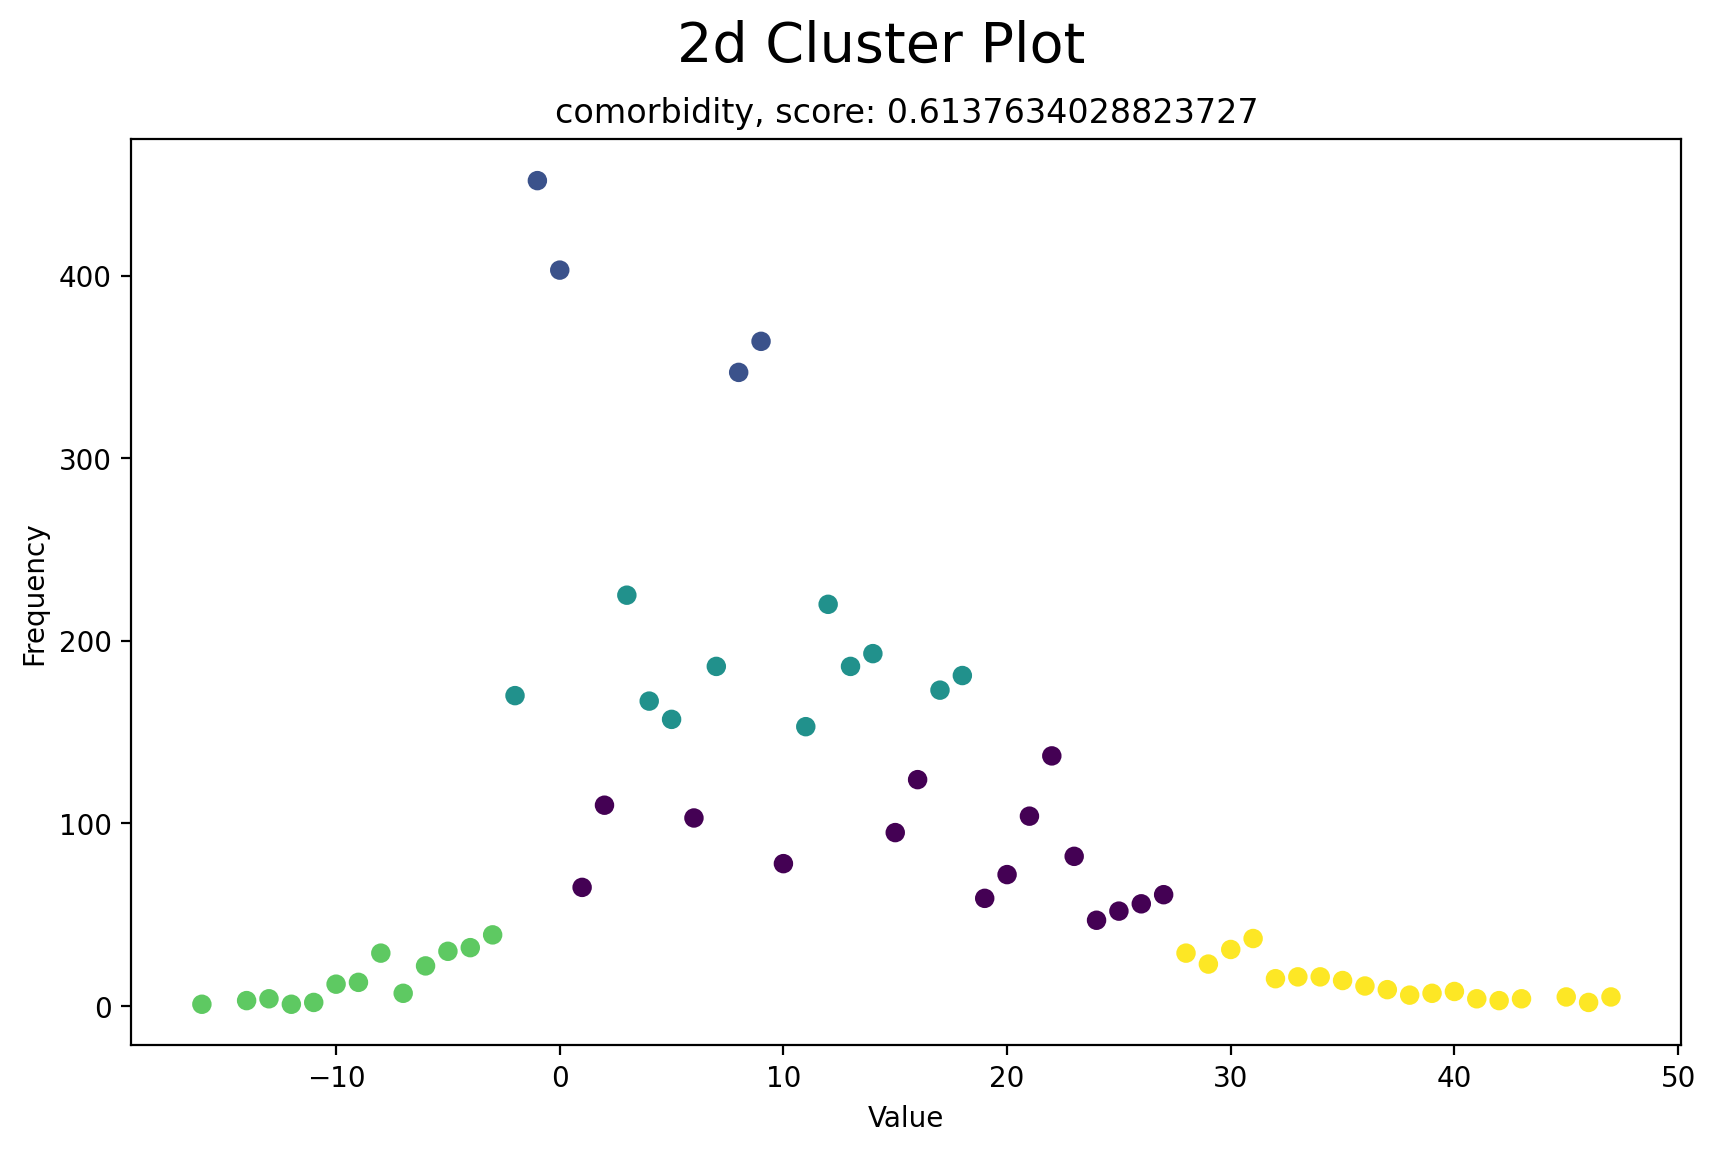

In [251]:
comorbidity = dataNeedingEncodingDF[['comorbidity']]

comorbidity = pd.DataFrame(data=list(zip(comorbidity.value_counts().index, comorbidity.value_counts().values)), columns=['comorbidity', 'count'])

comorbidity['comorbidity'] = comorbidity['comorbidity'].astype(str).apply(lambda x: x[1:-2]).astype(np.int64)

comorbidityDF = AgglomerativeClustering(n_clusters=5).fit_predict(np.asarray(comorbidity))

sil_x = np.dstack((comorbidity['comorbidity'], comorbidity['count']))[0]

score = silhouette_score(sil_x, comorbidityDF)

fig = plt.figure(figsize=(10,6), dpi=200)
fig.suptitle("2d Cluster Plot", fontsize=20)

plt.scatter(comorbidity['comorbidity'], comorbidity['count'], c=comorbidityDF)
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.title(f"comorbidity, score: {score}")
plt.show()

# Graphically representing the categorisation

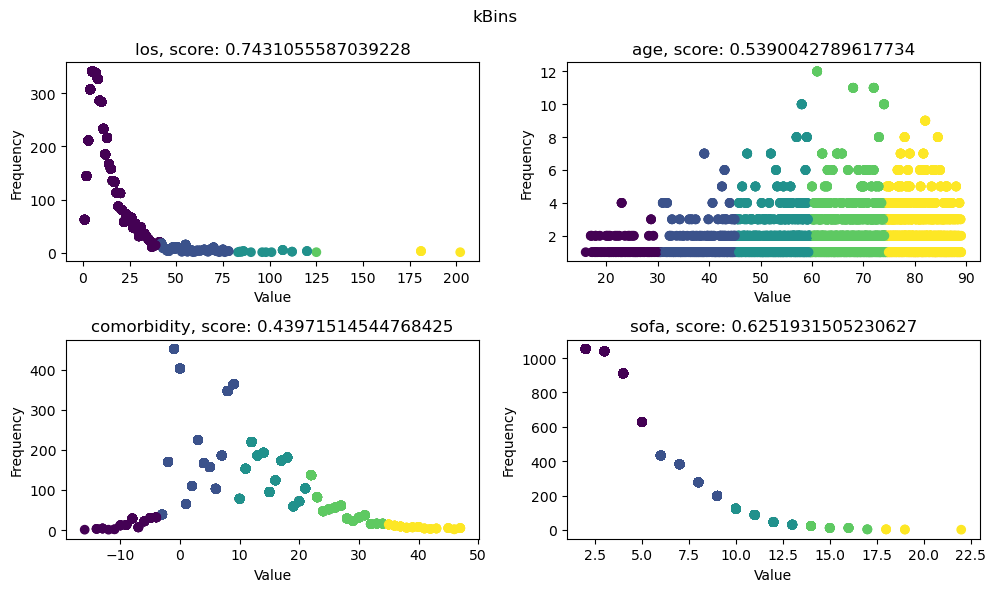

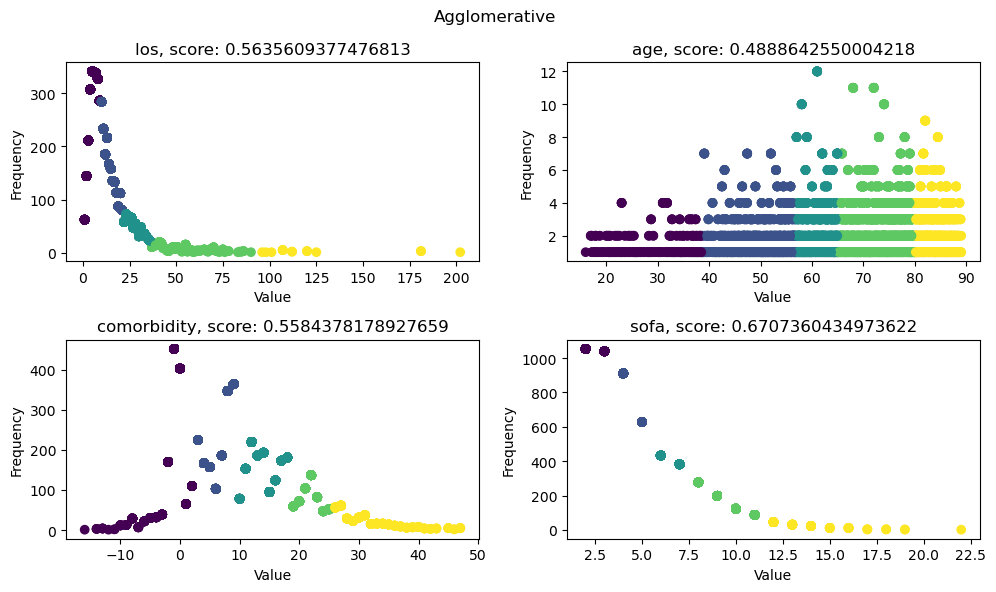

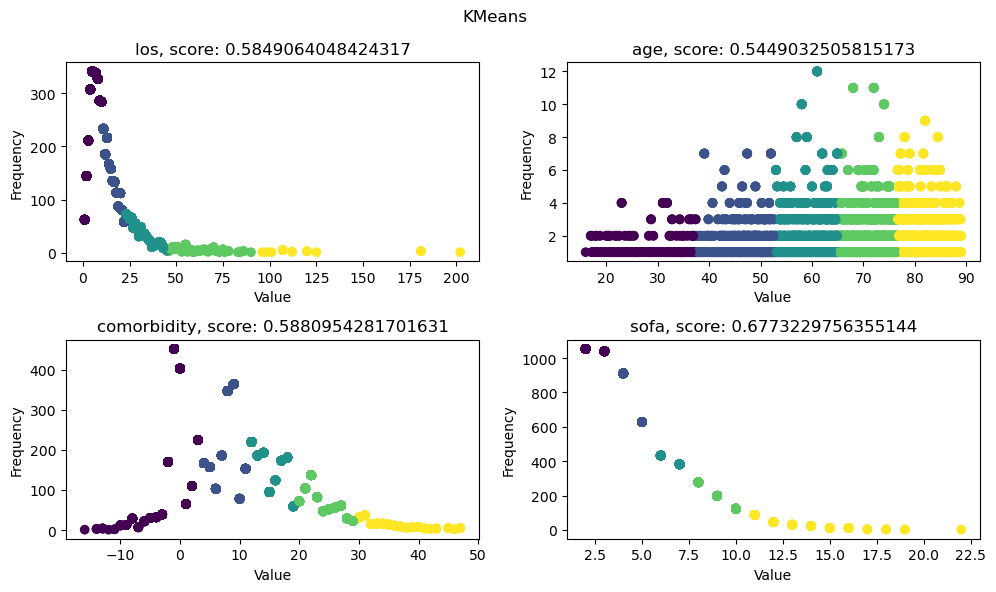

In [17]:
for type in categorisationTypes:

    df = categorisationTypes[type]

    fig = plt.figure(figsize=(10,6), dpi=100)

    fig.suptitle(f"{type}")

    for idx, col in enumerate(dataNeedingEncodingDF.columns):

        score = silhouette_score(np.asarray(dataNeedingEncodingDF[col]).reshape(-1,1), df[col])

        # print(dataNeedingEncodingDF[col][df[col]==0])

        plt.subplot(2, 2, idx+1)
        plt.scatter(dataNeedingEncodingDF[col], dataNeedingEncodingDF[col].map(dataNeedingEncodingDF[col].value_counts()), c=df[col])
        plt.xlabel("Value")
        plt.ylabel("Frequency")
        plt.title(f"{col}, score: {score}")

    plt.tight_layout()
    plt.show()

In [198]:
pd.set_option('display.max_rows', 1000)

In [18]:
categories = {0: 'very_low', 1: 'low', 2: 'medium', 3: 'high', 4: 'very_high'}


for type in categorisationTypes:

    categorisationTypes[type][['respiration','coagulation','liver','renal','cardiovascular','cns']] = mimicDF[['respiration','coagulation','liver','renal','cardiovascular','cns']]

    for col in categorisationTypes[type].columns:
        categorisationTypes[type][col] = categorisationTypes[type][col].map(categories)

    categorisationTypes[type]['gender'] = mimicDF['gender'].map({0:'male', 1:'female'})

    categorisationTypes[type] = pd.get_dummies(categorisationTypes[type])

    display(categorisationTypes[type])

,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,0,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5258,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5259,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
5260,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
5258,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
5259,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
5260,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


,los_high,los_low,los_medium,los_very_high,los_very_low,age_high,age_low,age_medium,age_very_high,age_very_low,...,cardiovascular_medium,cardiovascular_very_high,cardiovascular_very_low,cns_high,cns_low,cns_medium,cns_very_high,cns_very_low,gender_female,gender_male
0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,1
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5257,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
5258,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,1
5259,0,0,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,1
5260,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


### TODO Do we want to standardise the data before categorising?

If another point (eg an outlier) is added to the dataset, then this could push the other points away from their original categorisation. Need outlier detection? 

In [19]:
targetDF.describe()

,deathperiod
count,5262.000000
mean,0.896047
std,7.338713
min,-29.000000
25%,-1.000000
50%,-1.000000
75%,-1.000000
max,107.000000


In [20]:
targetDF

,deathperiod
0,-1
1,2
2,-1
3,-1
4,-1
...,...
5257,-1
5258,-1
5259,-1
5260,-1


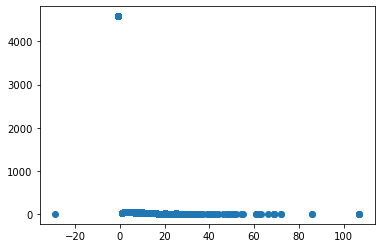

In [21]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()))
plt.show()

In [22]:
targetDF['deathperiod'] = targetDF['deathperiod'].apply(lambda x: x if x > -1 else -1)

In [23]:
targetDiedDF = targetDF[targetDF['deathperiod'] > -1]
targetNoDeathDF = targetDF[targetDF['deathperiod'] == -1].apply(lambda x: x+1.0)

In [24]:
targetDiedDF.shape

(678, 1)

In [25]:
targetNoDeathDF.shape

(4584, 1)

In [26]:
bins = 3

est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
targetCategorisedDF = pd.DataFrame(data=est.fit_transform(targetDiedDF), columns=['deathperiod'])

targetCategorisedDF['deathperiod'] = targetCategorisedDF['deathperiod'].apply(lambda x: x + 1)

targetCategorisedDF.set_index(targetDiedDF.index, inplace=True)

targetCategorisedDF.head()


,deathperiod
1,1.0
7,1.0
16,1.0
36,1.0
40,1.0


In [27]:
targetNoDeathDF.head()

,deathperiod
0,0.0
2,0.0
3,0.0
4,0.0
5,0.0


In [28]:
combinedTargetDF = pd.concat([targetCategorisedDF, targetNoDeathDF], axis=1)

withDeath = combinedTargetDF.iloc[:,0]
noDeath = combinedTargetDF.iloc[:,1]

newTargetDF = withDeath.fillna(noDeath)

newTargetDF = newTargetDF.astype(np.int64)

newTargetDF

0       0
1       1
2       0
3       0
4       0
       ..
5257    0
5258    0
5259    0
5260    0
5261    0
Name: deathperiod, Length: 5262, dtype: int64

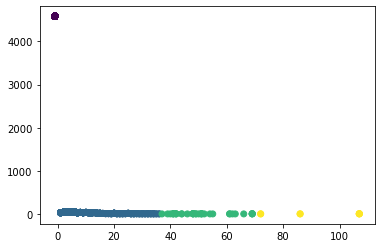

In [29]:
plt.scatter(targetDF['deathperiod'], targetDF['deathperiod'].map(targetDF['deathperiod'].value_counts()), c=newTargetDF)
plt.show()

### Here without the -1 value so we can see the variance of the rest

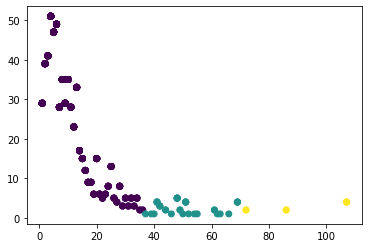

In [30]:
tempDF = targetDF[targetDF['deathperiod'] > -1]

plt.scatter(tempDF['deathperiod'], tempDF['deathperiod'].map(tempDF['deathperiod'].value_counts()), c=newTargetDF[newTargetDF> 0])
plt.show()

In [32]:
stackedTargetDF = np.stack(newTargetDF)

In [31]:
def score_classes(scorer, target_class):

    return scorer.explain(target_class)

In [33]:
class FOL:

    def __init__(self, features):
        self.features = features

    def __repr__(self):
        out = "\n("
        for i in range(len(self.features)):
            feature = self.features[i]
            if feature.sign == 'OR':
                out += ") \nOR \n("
                continue
            out += f"{feature}"
            if i+1 < len(self.features) and self.features[i+1].sign != 'OR':
                out += " AND "
        out += ")\n"
        return out


In [34]:
class Feature:

    def __init__(self, sign=None, number=None, name=None):
        self.sign = sign
        self.name = name
        self.number = number

    def __repr__(self):
        out = ""
        if self.sign is not None:
            if self.sign == -1:
                out += "NOT_"
            # out += f"{self.sign} "
        # if self.number is not None:
        #     out += f"{self.number} "
        if self.name is not None:
            out += f"{self.name}"
        return out

In [36]:
def convertFeaturesToColumnNames(explanation, columns):
    
    features = [x for x in explanation.split(" ") if x != '&']

    featureList = []

    for feature in features:
        f = Feature()
        if feature[0] == '|':
            f.sign = 'OR'
            featureList.append(f)
            continue
        if feature[-1] == ')':
            feature = feature[:-1]
        if feature[0] == '(':
            feature = feature[1:]
        if feature[0] == '~':
            f.sign = -1
        else:
            f.sign = 1
        f.number = int(feature[-2:])
        f.name = columns[f.number]
        featureList.append(f)
    
    # print(featureList)

    fol = FOL(featureList)

    # print(fol)

    return fol
        

    # return [columns[x] for x in featureNums]

In [37]:
list(categorisationTypes.keys())[:1]

['kBins']

In [ ]:
scores = {}


if __name__ == "__main__":
    for type in tqdm(list(categorisationTypes.keys())[:1]):
        data = categorisationTypes[type].to_numpy()

        target = stackedTargetDF

        scorer = Scorer(data, target)

        scorer.train()

        scorer.model.share_memory()

        processes = []
        tempScores = []

        tempScores.append(score_classes(scorer, 1))

        formattedScores = []

        for score in tempScores:
            if score[0] != None:
                temp = []
                temp.append(convertFeaturesToColumnNames(score[0], categorisationTypes[type].columns))
                temp.extend(score[1:])
                formattedScores.append(temp)


        # for target_class in newTargetDF.unique():

        #     tempScores.append(score_classes(scorer, target_class))

            # p = mp.Process(target=score_classes, args=(scorer, target_class, tempScores))
            # p.start()
            # processes.append(p)

        # [p.join() for p in processes]
        # for p in processes:
        #     p.join()

        # tempScores = [scorer.explain(target_class) for target_class in newTargetDF.unique()]

        scores[type] = {i: formattedScores[i] for i in range(len(formattedScores))} 

    print(scores)

  0%|          | 0/1 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
tempScores

NameError: name 'tempScores' is not defined

In [ ]:
formattedScores

[[(cns_very_high AND NOT_los_low AND NOT_sofa_high) 
  OR 
  (respiration_very_high AND NOT_los_low AND NOT_cardiovascular_medium AND NOT_cns_high AND NOT_cns_very_high) 
  OR 
  (cns_high AND NOT_los_high AND NOT_los_low AND NOT_age_low AND NOT_sofa_medium AND NOT_coagulation_low),
  14,
  0.5746755217637307,
  array([False, False, False, ..., False, False, False])]]

In [ ]:
# print(scores['kBins'][0][0])
print(convertFeaturesToColumnNames(scores['kBins'][0][0], categorisationTypes['kBins'].columns))

AttributeError: 'FOL' object has no attribute 'split'